In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
base_time = datetime.strptime("00:00:00", "%H:%M:%S")
df = pd.read_parquet("combined1minutedata.parquet")
df["underlying_price"] = df["underlying_price"].astype(float)
df.loc[:, "time"] = df["ms_of_day"].apply(
    lambda ms_of_day: (base_time + timedelta(milliseconds=ms_of_day)).time()
)
df.set_index(["date", "time"], inplace=True)

In [ ]:
ROLLING_WINDOW = 30

def garch_calc(rtn):
    am = arch_model(rtn.dropna().values*100)
    res = am.fit(disp="off")
    forecasts = res.forecast(horizon=5)
    # 390 minutes per day
    vol_forecast = (
        forecasts.residual_variance.iloc[-1, :].sum() * 390 / 5
    ) ** 0.5 / 100
    return vol_forecast

def sigma(price, method="garch"):
    if method == "hist":
        return (price.pct_change()*100).std() * (390**0.5)
    elif method == "garch":
        return garch_calc(price.pct_change()*100)
    elif method == "realized":
        return np.sqrt(((price.pct_change()*100)**2).sum()) * np.sqrt(
            390
        )

def find_atm(underlying_price, strike):
    price = underlying_price.iloc[0]
    closest_index = np.argmin(np.abs((strike.values - price)))
    closest_value = strike.iloc[closest_index]
    return closest_value


def plot_volatility(df,DAY):
    df.index = pd.to_datetime(df.index, format="%H:%M:%S", errors="coerce")
    # Create the primary plot (left y-axis)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df["Garch_Vlty"], color="blue", label="Garch Volatility")
    ax.plot(
        df.index, df["Hist_Vlty"], color="green", label="Historical Volatility"
    )
    ax.plot(df.index, df["ATM_CALL_IV"], color="#00CCCC", label="ATM_CALL_IV")
    ax.plot(df.index, df["ATM_PUT_IV"], color="#00DDDD", label="ATM_PUT_IV")

    # Customize the primary y-axis (left)
    ax.set_ylabel("Volatility", color="blue")
    ax.tick_params(axis='y', colors='blue')

    # Create a secondary y-axis (right y-axis)
    ax2 = ax.twinx()
    ax2.plot(df.index, df['Price'], color='red', label='Price')

    # Customize the secondary y-axis (right)
    ax2.set_ylabel("Price", color='red')
    ax2.tick_params(axis='y', colors='red')

    # Customize x-axis to show time in grid and align with clock
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set ticks every 30 minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM

    # Add grid
    ax.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Improve layout
    plt.xlabel("Time")
    plt.title(f"Volatility and Price Over Time on {DAY}")
    plt.tight_layout()

    # Add legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()



In [66]:
DAY = "20250207"

def chart_by_day(DAY):
    df_day_price = df.groupby(["date", "time"])["underlying_price"].first()
    df_vlty = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .rolling(ROLLING_WINDOW)
        .apply(lambda x: sigma(x, method="garch"))
        .reset_index()
        .set_index("time")
    )
    df_histvlty = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .rolling(ROLLING_WINDOW)
        .apply(lambda x: sigma(x, method="hist"))
        .reset_index()
        .set_index("time")
    )

    df_price = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .reset_index()
        .set_index("time")
    )

    df_day_call = (
        df.loc[(df.index.get_level_values(0) == DAY) & (df["right"] == "C")]
        .reset_index()
        .set_index("time")
    )
    df_day_call.loc[:, "atm"] = df_day_call.groupby(["time"]).apply(
        lambda rows: find_atm(rows["underlying_price"], rows["strike"])
    )
    df_atmcall_iv=df_day_call.loc[df_day_call["strike"] == df_day_call["atm"]]["implied_vol"].to_frame()
    # df_call_atm = df_day_call.groupby("time")["atm"].first().to_frame()


    df_day_put = (
        df.loc[(df.index.get_level_values(0) == DAY) & (df["right"] == "P")]
        .reset_index()
        .set_index("time")
    )
    df_day_put.loc[:, "atm"] = df_day_put.groupby(["time"]).apply(
        lambda rows: find_atm(rows["underlying_price"], rows["strike"])
    )
    # df_put_atm = df_day_put.groupby("time")["atm"].first().to_frame()
    df_atmput_iv = df_day_put.loc[df_day_put["strike"] == df_day_put["atm"]][
        "implied_vol"
    ].to_frame()

    df_vlty = pd.concat(
        [
            df_vlty["underlying_price"],
            df_histvlty["underlying_price"],
            df_price["underlying_price"],
            df_atmcall_iv["implied_vol"],
            df_atmput_iv["implied_vol"],
        ],
        axis=1,
    )
    df_vlty.columns = ["Garch_Vlty", "Hist_Vlty", "Price", "ATM_CALL_IV", "ATM_PUT_IV"]
    df_vlty = df_vlty.fillna(0)
    plot_volatility(df_vlty, DAY=DAY)

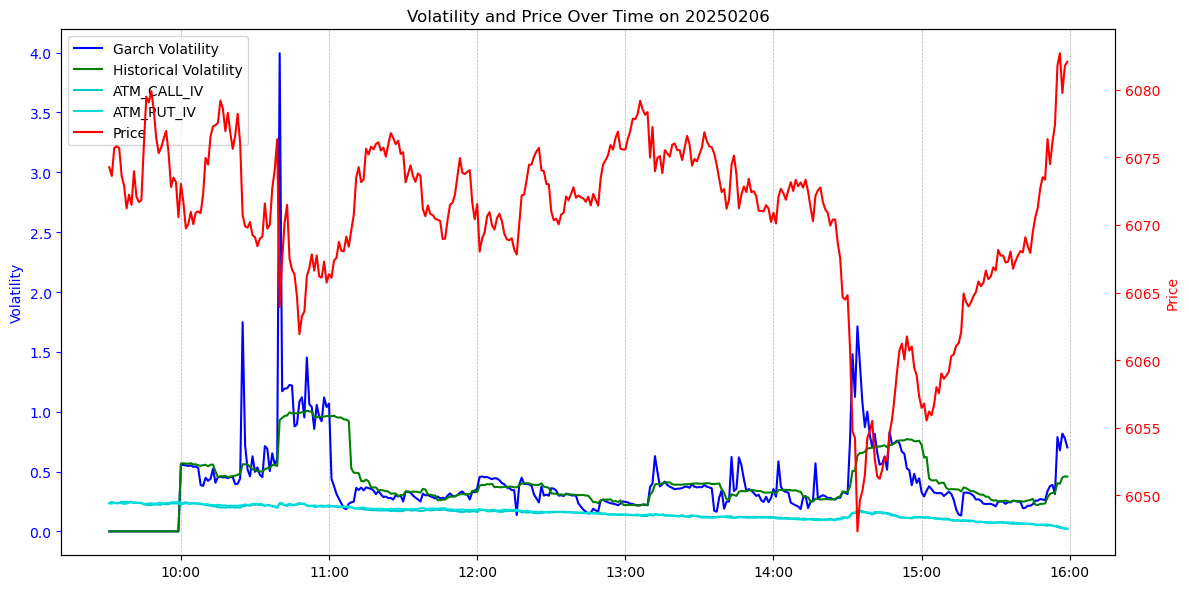

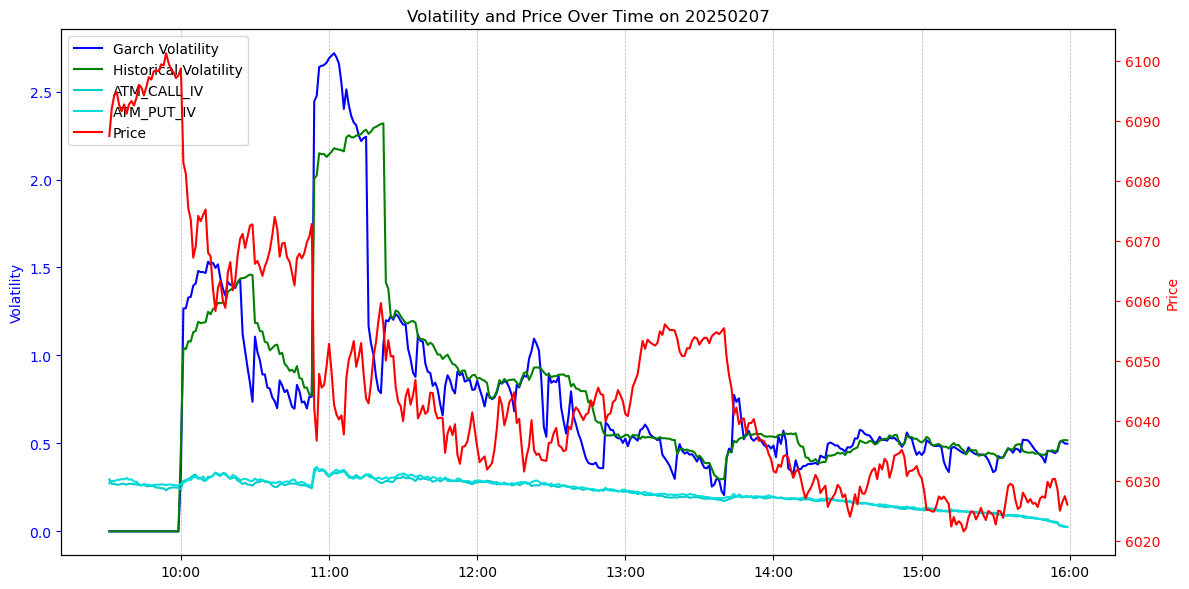

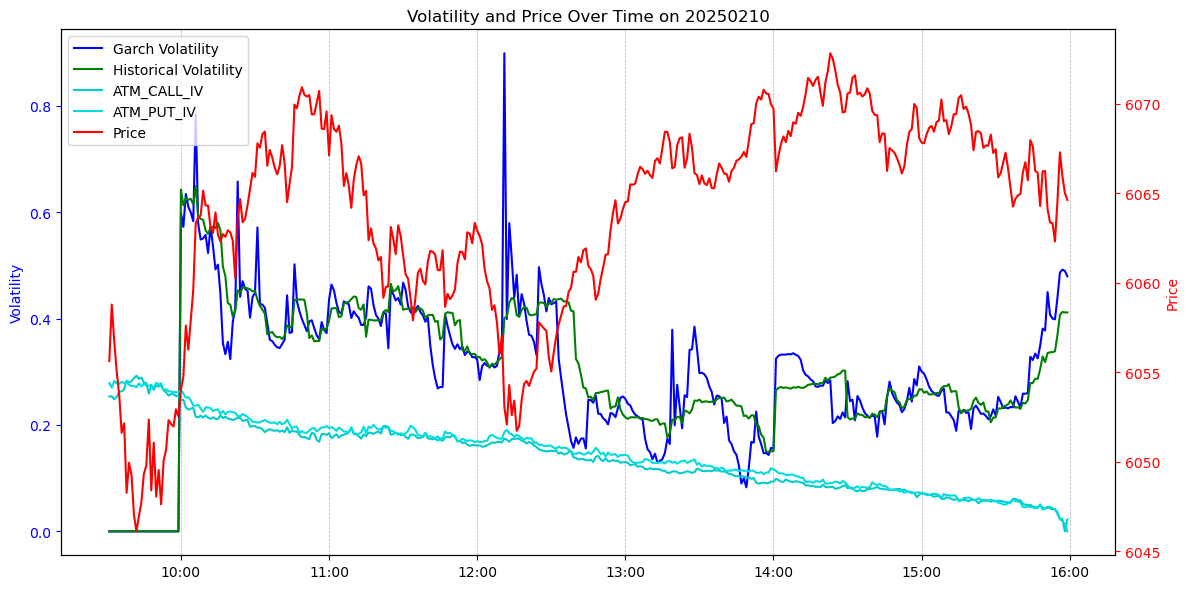

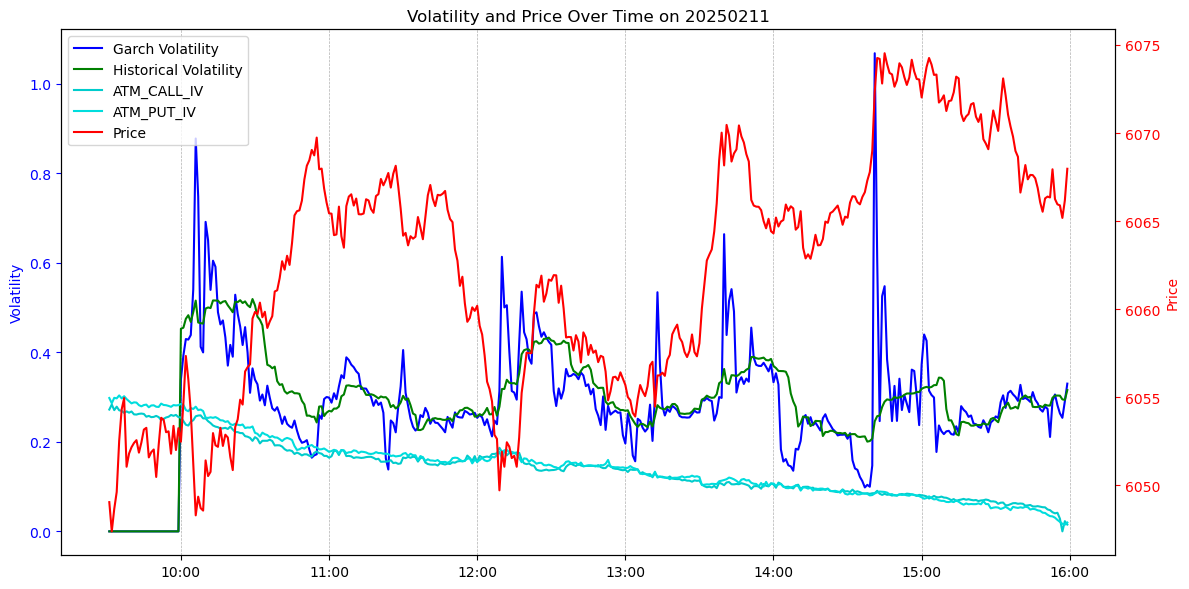

In [68]:
chart_by_day("20250206")
chart_by_day("20250207")
chart_by_day("20250210")
chart_by_day("20250211")

In [ ]:
df_day.loc[:, "extrinsic"] = (
    np.maximum(0, df_day["underlying_price"] - df_day["strike"]) + df_day["mid"]
)
df_day

C:\Users\hui\AppData\Local\Temp\ipykernel_33576\1724426471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day.loc[:, "extrinsic"] = (


,date,ms_of_day,strike,right,underlying_price,bid,ask,mid,delta,implied_vol,OTMAmount,EOD_PnL,extrinsic
12289260,09:31:00,34260000,6065.0,C,6064.72,13.2,13.50,13.350,0.4990,0.2739,0.28,-36.570,13.350
12289261,09:31:00,34260000,6070.0,C,6064.72,10.6,10.90,10.750,0.4388,0.2684,5.28,-34.170,10.750
12289262,09:31:00,34260000,6075.0,C,6064.72,8.4,8.50,8.450,0.3775,0.2628,10.28,-31.470,8.450
12289263,09:31:00,34260000,6080.0,C,6064.72,6.4,6.60,6.500,0.3173,0.2579,15.28,-28.420,6.500
12289264,09:31:00,34260000,6085.0,C,6064.72,4.8,4.90,4.850,0.2592,0.2527,20.28,-25.070,4.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302868,15:56:00,57360000,6120.0,C,6113.95,0.1,0.20,0.150,0.0790,0.0339,6.05,0.150,0.150
12302869,15:57:00,57420000,6115.0,C,6114.30,1.2,1.30,1.250,0.4386,0.0308,0.70,1.250,1.250
12302871,15:58:00,57480000,6120.0,C,6115.53,0.1,0.15,0.125,0.0830,0.0253,4.47,0.125,0.125
12302873,15:59:00,57540000,6120.0,C,6116.38,0.1,0.15,0.125,0.0950,0.0216,3.62,0.125,0.125


: 